<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/COCO_Dataset_dog_unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import os

In [18]:
# 데이터셋 구현
class COCODataset(Dataset):
    def __init__(self, root_dir, set_name, transform=None):
        self.root_dir = root_dir
        self.set_name = set_name
        self.transform = transform
        # COCO 객체 생성
        self.coco = COCO(os.path.join(self.root_dir, "annotations", "instances_{}.json".format(self.set_name)))
        # 카테고리 id 반환, dog == 18
        self.cat_ids = self.coco.getCatIds(catNms=['dog'])
        # 카테고리 id에 만족하는 이미지 id 반환
        # 여기다가 [0:400]하면 될려나?
        # dog 카테고리 이미지 수 : 4385
        self.img_ids = self.coco.getImgIds(catIds=self.cat_ids)
        # self.img_ids = random.sample(img_ids, 400)

    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        # 이미지에 대한 메타데이터 로드
        # dictionary of metadata for the image, including the file path, image height and width, and other information.
        img_info = self.coco.loadImgs(self.img_ids[idx])[0]
        # 이미지 경로(이미지 이름?)
        img_path = os.path.join(self.root_dir, self.set_name, img_info['file_name'])
        # 이미지 열기
        img = Image.open(img_path).convert('RGB')
        # 영행렬 제작.
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        # 해당 이미지에 해당하는 어노테이션 정보를 얻는다.
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        # mask 이미지 제작
        # 0 black / 1 white
        # np.maximum : combine the current instance mask with the accumulated mask by taking the element-wise maximum of the two masks.
        # The end result is a binary segmentation mask that represents all the instances of the object in the current image.
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann)*255)
        # NumPy 배열을 PIL 이미지로 변환 
        mask = Image.fromarray(mask)
        # transform
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
      
        return img, mask

In [19]:
# Resize, ToTensor만 진행하였음.
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [20]:
# Conv -> Norm -> ReLU 두번 반복
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

# UNet
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.center = DoubleConv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = DoubleConv(128, 64)
        self.final = nn.Conv2d(64, 1, kernel_size=1)
    
    def forward(self, x):
        conv1 = self.down1(x)
        pool1 = self.pool1(conv1)
        conv2 = self.down2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.down3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.down4(pool3)
        pool4 = self.pool4(conv4)
        center = self.center(pool4)
        up4 = self.up4(center)
        concat4 = torch.cat([up4, conv4], dim=1)
        upconv4 = self.upconv4(concat4)
        up3 = self.up3(upconv4)
        concat3 = torch.cat([up3, conv3], dim=1)
        upconv3 = self.upconv3(concat3)
        up2 = self.up2(upconv3)
        concat2 = torch.cat([up2, conv2], dim=1)
        upconv2 = self.upconv2(concat2)
        up1 = self.up1(upconv2)
        concat1 = torch.cat([up1, conv1], dim=1)
        upconv1 = self.upconv1(concat1)
        output = self.final(upconv1)
        return output

In [21]:
# trainset, dataloader 정의
trainset = COCODataset('/content/drive/MyDrive/COCO2017', 'train2017', transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

loading annotations into memory...
Done (t=18.19s)
creating index...
index created!


In [22]:
# 모델 생성 및 하이퍼파라미터 지정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5

In [23]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.675
[1,    20] loss: 0.638
[1,    30] loss: 0.604
[1,    40] loss: 0.548
[1,    50] loss: 0.503
[1,    60] loss: 0.505
[1,    70] loss: 0.484
[1,    80] loss: 0.451
[1,    90] loss: 0.456
[1,   100] loss: 0.435
[1,   110] loss: 0.449
[1,   120] loss: 0.447
[1,   130] loss: 0.406
[1,   140] loss: 0.456
[1,   150] loss: 0.408
[1,   160] loss: 0.443
[1,   170] loss: 0.439
[1,   180] loss: 0.407
[1,   190] loss: 0.422
[1,   200] loss: 0.411
[1,   210] loss: 0.413
[1,   220] loss: 0.424
[1,   230] loss: 0.406
[1,   240] loss: 0.367
[1,   250] loss: 0.401
[1,   260] loss: 0.377
[1,   270] loss: 0.343
[1,   280] loss: 0.427
[1,   290] loss: 0.353
[1,   300] loss: 0.408
[1,   310] loss: 0.419
[1,   320] loss: 0.332
[1,   330] loss: 0.337
[1,   340] loss: 0.402
[1,   350] loss: 0.389
[1,   360] loss: 0.379
[1,   370] loss: 0.391
[1,   380] loss: 0.394
[1,   390] loss: 0.390
[1,   400] loss: 0.386
[1,   410] loss: 0.360
[1,   420] loss: 0.371
[1,   430] loss: 0.360
[1,   440] 

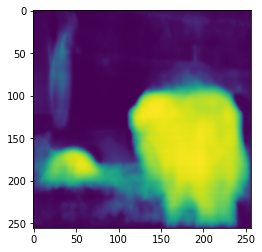

In [24]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    model.eval()
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)
        output = output.squeeze(0).cpu().numpy()
        output = output.transpose(1,2,0)
    plt.imshow(output)
    plt.show()

predict_image('/content/drive/MyDrive/doggy.jpg')

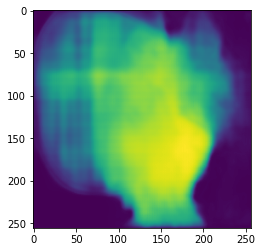

In [27]:
import matplotlib.pyplot as plt

def predict_image(image_path):
    model.eval()
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)
        output = output.squeeze(0).cpu().numpy()
        output = output.transpose(1,2,0)
    plt.imshow(output)
    plt.show()

predict_image('/content/drive/MyDrive/dog.jpg')